In [1]:
from numba import njit, jit, int32, cuda
import numba
import numpy as np
import time
from time import time
from matplotlib import pyplot as plt
import pandas as pd
import timeit

x1 = 1_000
x2 = 10_000
x3 = 100_000
x4 = 1_000_000

x =[x1, x2, x3, x4]

v1 = np.random.random_integers(0, 10, x1)
v2 = np.random.random_integers(0, 10, x2)
v3 = np.random.random_integers(0, 10, x3)
v4 = np.random.random_integers(0, 10, x4)
k = [v1, v2, v3, v4]

c1 = np.zeros(1, dtype = np.int32)

time_cpu = []

for i in k:
  print('k =', i.shape)
  start_time = timeit.default_timer() 
  m1 = i.sum()
  cpu_finish_time = timeit.default_timer() - start_time
  time_cpu.append(cpu_finish_time) 
  print(m1, cpu_finish_time)
  #lines = plt.plot(m, time_cpu, '-go', x2, y2, 's:m')
  #plt.plot(m, time_cpu, ':o')
  print('sum'.center(80, '-'))


k = (1000,)
5184 5.211799999926825e-05
--------------------------------------sum---------------------------------------
k = (10000,)
49944 0.0006076140000033092
--------------------------------------sum---------------------------------------
k = (100000,)
499752 0.0006766510000062453
--------------------------------------sum---------------------------------------
k = (1000000,)
5001288 0.0007418199999875696
--------------------------------------sum---------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead


In [2]:
TPB = 32

@cuda.jit
def dev_vec_sum(a, c):
  sh_b = cuda.shared.array(TPB, int32)

  thread_id = cuda.threadIdx.x
  block_id = cuda.blockIdx.x
  idx = thread_id + block_id * TPB
  sh_b[thread_id] = 0

  if idx < a.shape[0]:
    sh_b[thread_id] = a[idx]
    cuda.syncthreads()
    if cuda.threadIdx.x == 0:
      sum_of_arr = 0
      for i in range(TPB):
        sum_of_arr += sh_b[i]
        
      cuda.atomic.add(c, 0, sum_of_arr)

def DeviceHost(a, c):
    dev_a = cuda.to_device(a)
    dev_c = cuda.to_device(c)
    dev_vec_sum[TPB, TPB](dev_a, dev_c)
    c = dev_c.copy_to_host()
    return c

In [3]:
time_gpu = []


def result_gpu(my_a):
  for i in range(len(my_a)):
    global end
    start_time = timeit.default_timer() 
    DeviceHost(my_a[i], c1) # где с1 - результат суммирования
    end = timeit.default_timer() - start_time
    time_gpu.append(end)
    print(time_gpu)
    print('Расчёт на GPU: ')
    print(end)
    print(f'При размере вектора: {len(my_a[i])}')
    print('--------------------------------')

In [4]:
result_gpu(k)

[0.9704213969999955]
Расчёт на GPU: 
0.9704213969999955
При размере вектора: 1000
--------------------------------
[0.9704213969999955, 0.002879610000007915]
Расчёт на GPU: 
0.002879610000007915
При размере вектора: 10000
--------------------------------
[0.9704213969999955, 0.002879610000007915, 0.0028092390000011846]
Расчёт на GPU: 
0.0028092390000011846
При размере вектора: 100000
--------------------------------
[0.9704213969999955, 0.002879610000007915, 0.0028092390000011846, 0.005104399999993348]
Расчёт на GPU: 
0.005104399999993348
При размере вектора: 1000000
--------------------------------


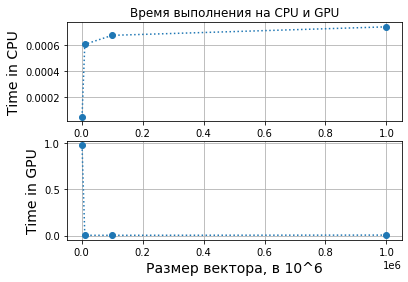

In [5]:
plt.subplot(2, 1, 1)
plt.plot(x, time_cpu, ':o')               
plt.title("Время выполнения на CPU и GPU") 
plt.ylabel("Time in CPU", fontsize=14) 
plt.grid(True)                
plt.subplot(2, 1, 2)

plt.plot(x, time_gpu, ':o')               
plt.xlabel("Размер вектора, в 10^6", fontsize=14)  
plt.ylabel("Time in GPU", fontsize=14) 
plt.grid(True)  

In [6]:
time_gpu

[0.9704213969999955,
 0.002879610000007915,
 0.0028092390000011846,
 0.005104399999993348]

In [7]:
@cuda.jit
def dev_vec_sum_no_host(a, c):
  sh_b = cuda.shared.array(TPB, int32)

  thread_id = cuda.threadIdx.x
  block_id = cuda.blockIdx.x
  idx = thread_id + block_id * TPB
  sh_b[thread_id] = 0

  if idx < a.shape[0]:
    sh_b[thread_id] = a[idx]
    cuda.syncthreads()
    if cuda.threadIdx.x == 0:
      sum_of_arr = 0
      for i in range(TPB):
        sum_of_arr += sh_b[i]
        
      cuda.atomic.add(c, 0, sum_of_arr)

In [8]:
time_gpu_no_host = []
def DeviceHost_no_host(a, c):
    global end1
    dev_a = cuda.to_device(a)
    dev_c = cuda.to_device(c)

    start_time = timeit.default_timer() 
    dev_vec_sum_no_host[TPB, TPB](dev_a, dev_c)
    end1 = timeit.default_timer() - start_time

    time_gpu_no_host.append(end1)
    print(time_gpu_no_host)
    print('Расчёт на GPU без переноса на хост: ')
    print(end1)
    print(f'При размере вектора: {len(a)}')
    print('--------------------------------')

    c = dev_c.copy_to_host()

In [10]:
def result_gpu_no_hostcopy(my_a):
  for i in range(len(my_a)):
    DeviceHost_no_host(my_a[i], c1)

In [11]:
result_gpu_no_hostcopy(k)

[0.2287371070000006]
Расчёт на GPU без переноса на хост: 
0.2287371070000006
При размере вектора: 1000
--------------------------------
[0.2287371070000006, 0.0005294580000168025]
Расчёт на GPU без переноса на хост: 
0.0005294580000168025
При размере вектора: 10000
--------------------------------
[0.2287371070000006, 0.0005294580000168025, 0.0003350389999923209]
Расчёт на GPU без переноса на хост: 
0.0003350389999923209
При размере вектора: 100000
--------------------------------
[0.2287371070000006, 0.0005294580000168025, 0.0003350389999923209, 0.00024218400000108886]
Расчёт на GPU без переноса на хост: 
0.00024218400000108886
При размере вектора: 1000000
--------------------------------


In [12]:
time_gpu_no_host

[0.2287371070000006,
 0.0005294580000168025,
 0.0003350389999923209,
 0.00024218400000108886]

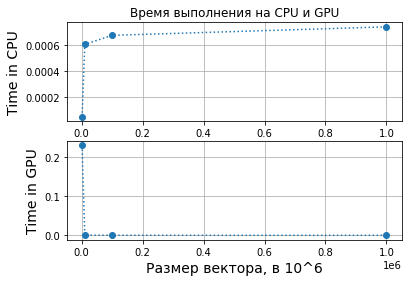

In [13]:
plt.subplot(2, 1, 1)
plt.plot(x, time_cpu, ':o')               
plt.title("Время выполнения на CPU и GPU") 
plt.ylabel("Time in CPU", fontsize=14) 
plt.grid(True)                
plt.subplot(2, 1, 2)

plt.plot(x, time_gpu_no_host, ':o')               
plt.xlabel("Размер вектора, в 10^6", fontsize=14)  
plt.ylabel("Time in GPU", fontsize=14) 
plt.grid(True) 

In [14]:
time_gpu_no_host

[0.2287371070000006,
 0.0005294580000168025,
 0.0003350389999923209,
 0.00024218400000108886]

In [ ]:
result_gpu(k)

Расчёт на GPU: 
0.003937530000257539
При размере вектора: 1000
--------------------------------
Расчёт на GPU: 
0.004289985000468732
При размере вектора: 10000
--------------------------------
Расчёт на GPU: 
0.005912063000323542
При размере вектора: 100000
--------------------------------
Расчёт на GPU: 
0.004826651000257698
При размере вектора: 1000000
--------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


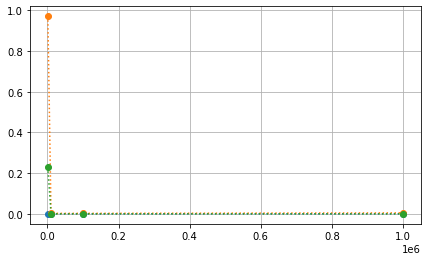

In [15]:
fig = plt.figure(figsize=(7, 4))
plt.grid()

ax = fig.add_subplot()

ax.plot(x, time_cpu, ':o')
ax.plot(x, time_gpu, ':o')
ax.plot(x, time_gpu_no_host, ':o')
plt.show()

In [16]:
compar_pd = pd.DataFrame({'GPU': [time_gpu[0], time_gpu[1], time_gpu[2], time_gpu[3]], 'CPU': [time_cpu[0], time_cpu[1], time_cpu[2], time_cpu[3]], 'GPU no host': [time_gpu_no_host[0], time_gpu_no_host[1], time_gpu_no_host[2], time_gpu_no_host[3]] }, index = [x1, x2, x3, x4] )
compar_pd

,GPU,CPU,GPU no host
1000,0.970421,0.000052,0.228737
10000,0.002880,0.000608,0.000529
100000,0.002809,0.000677,0.000335
1000000,0.005104,0.000742,0.000242
